In [15]:
import numpy as np
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig
import matplotlib.pyplot as plt
from pandas import DataFrame
import emcee
import copy
import pickle

In [16]:
POSTERIOR_DIR = "../data/posteriors/"
FIGURES_DIR = "../figures/forecasts/"

In [17]:
# # load forecast samples pickled object
# with open('../data/samples/forecast_samples_w0waCDM.pkl', 'rb') as f:
#     forecast_samples = pickle.load(f)

# # remove the suffix 'tab:' from the color names
# for sample_key in forecast_samples.keys():
#     if 'color' in forecast_samples[sample_key]:
#         forecast_samples[sample_key]['color'] = forecast_samples[sample_key]['color'].replace('tab:', '')

# forecast_samples['lsst_4most_spec-z_sigma_v']['color'] = 'purple'
# # forecast_samples['joint_PDSPL_only']['color'] = 'orange'

# # don't use joint_PDSPL_only for now
# forecast_samples.pop('joint_PDSPL_only', None);

In [18]:
forecast_samples = {
    "DSPL": {
        "name": "DSPL (87 lenses)",
        "color": "blue",
        "wCDM": {}, # store emcee backend and samples here
        "w0waCDM":{},
    },
    "lsst_y10": {
        "name": "PDSPL (LSST Y10)",
        "color": "green",
        "wCDM": {},
        "w0waCDM":{},
    },
    "lsst_4most_spec-z": {
        "name": "PDSPL (4MOST $z^{\\rm spec}$)",
        "color": "red",
        "wCDM": {},
        "w0waCDM":{},
    },
    "lsst_4most_spec-z_sigma_v": {
        "name": "PDSPL (4MOST $z^{\\rm spec}$ + $\\sigma_{v, D}$)",
        "color": "purple",
        "wCDM": {},
        "w0waCDM":{},
    },
    "joint_PDSPL_only": {
        "name": "Joint PDSPL",
        "color": "orange",
        "wCDM": {},
        "w0waCDM":{},
    },
}

plotting_order_keys = [
    # "DSPL",
    # "lsst_4most_spec-z",
    # "lsst_4most_spec-z_sigma_v",
    "lsst_y10",
    "joint_PDSPL_only",
]

## Figures for $w_0w_a$-CDM cosmology forecast 

In [19]:
# load posterior samples
columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            # '$\\sigma(\\gamma_{\\rm pl, global})$'
            ]


for key in forecast_samples.keys():
    forecast_samples[key]["w0waCDM"]["emcee_backend"] = emcee.backends.HDFBackend(
        POSTERIOR_DIR + f"{key}_w0waCDM.h5", read_only=True
    )
    samples = forecast_samples[key]["w0waCDM"]["emcee_backend"].get_chain(flat = True,
                                                                  discard=500,
                                                                  thin=100)
    forecast_samples[key]["emcee_samples"] = samples

    df = DataFrame(samples, columns=columns)
    forecast_samples[key]["w0waCDM"]["chainconsumer_chain"] = Chain(
        samples=df, name=forecast_samples[key]["name"], 
        color=forecast_samples[key]["color"],
        kde=1.5, 
        shade=True,
        shade_alpha=1.0,
        linewidth=2,
    )

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w_0$ & $w_{\rm a}$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		PDSPL (LSST Y10) & $0.24^{+0.15}_{-0.16}$ & $-0.95^{+0.24}_{-0.23}$ & $0.6^{+1.2}_{-1.4}$ & $1.020^{+0.025}_{-0.023}$ & $2.050^{+0.038}_{-0.040}$ \\ 
		Joint PDSPL & $0.26^{+0.15}_{-0.18}$ & $-0.92^{+0.18}_{-0.16}$ & $0.4^{+1.0}_{-1.3}$ & $1.018\pm 0.021$ & $2.057^{+0.035}_{-0.034}$ \\ 
		\hline
    \end{tabular}
\end{table}


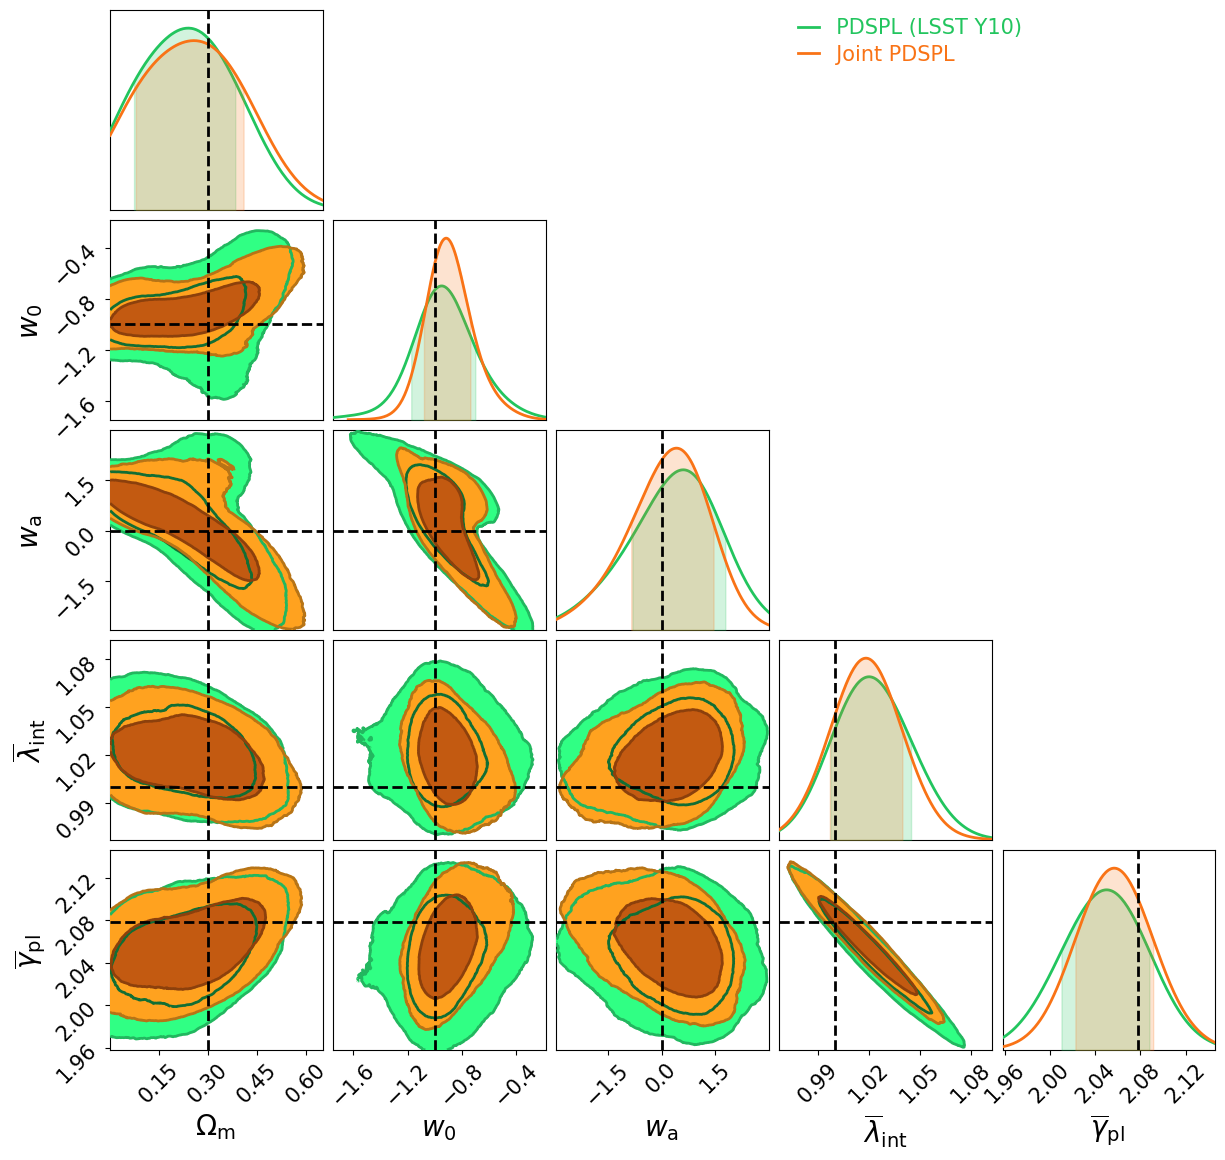

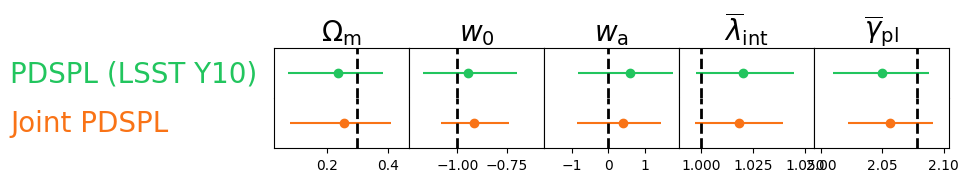

In [20]:
# plot the forecast results using chainconsumer

c = ChainConsumer()

for key in plotting_order_keys:
    c.add_chain(forecast_samples[key]["w0waCDM"]["chainconsumer_chain"])

c.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": 0.3,
        r"$w_0$": -1,
        r"$w_{\rm a}$": 0,
        r"$\overline{\lambda}_{\rm int}$": 1.0,
        r"$\overline{\gamma}_{\rm pl}$": 2.078,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }, line_width=2)
)

extents = {
                r"$\Omega_{\rm m}$": [0.1, 0.5],
                r"$w_0$": [-2, 0],
                r"$w_{\rm a}$": [-3, 3],
                r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
                r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
                # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
            }

c.plotter.set_config(
    PlotConfig(
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15, 
            label_font_size=20,
        )
)

c.plotter.plot(
    filename = FIGURES_DIR + "forecast_w0waCDM.pdf",
);

c.plotter.plot_summary(errorbar=True);
latex_table = c.analysis.get_latex_table()
print(latex_table)


### Prior on $\Omega_{\rm m}$

In [21]:
# external priors

# sigma_lambda_prior = 0.01
# sigma_gamma_prior = 0.01
sigma_omega_m_prior = 0.05
# sigma_wa_prior = 0.4

om_true = 0.3
w_true = -1


#flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

#print(joint_chain.samples[r"$\overline{\lambda}_{\rm int}$"])

def add_prior_to_chain(chain):
    chain_weights = copy.deepcopy(chain)
    # lambda_int = chain.samples[r"$\overline{\lambda}_{\rm int}$"]
    om = chain.samples[r"$\Omega_{\rm m}$"]
    # gamma_pl = chain.samples[r"$\overline{\gamma}_{\rm pl}$"]
    # wa = chain.samples[r"$w_{\rm a}$"]
    weights_om = -(om - om_true)**2 / (2*sigma_omega_m_prior**2)
    # weights_lambda = -(lambda_int - lambda_mst_mean)**2 / (2*sigma_lambda_prior**2)
    # weights_gamma = -(gamma_pl - gamma_pl_mean)**2 / (2*sigma_gamma_prior**2)
    # weights_wa = -(wa - wa_true)**2 / (2*sigma_wa_prior**2)
    # weights = np.exp(weights_gamma + weights_lambda + weights_om + weights_wa)
    weights = np.exp(weights_om)
    weights[weights < 10**(-10)] = 10**(-10)
    chain_weights.samples["weight"] = weights
    chain_weights.name = chain.name+" + $\\Omega_{\\rm m}$ prior"
    return chain_weights

In [22]:
for key in forecast_samples.keys():
    chain = forecast_samples[key]['w0waCDM']['chainconsumer_chain']
    chain_with_prior = add_prior_to_chain(chain)
    forecast_samples[key]['w0waCDM']['chainconsumer_chain_with_prior'] = chain_with_prior

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w_0$ & $w_{\rm a}$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		PDSPL (LSST Y10) + $\Omega_{\rm m}$ prior & $0.291^{+0.058}_{-0.054}$ & $-0.92\pm 0.23$ & $-0.2^{+1.5}_{-1.1}$ & $1.019^{+0.023}_{-0.021}$ & $2.053^{+0.034}_{-0.039}$ \\ 
		Joint PDSPL + $\Omega_{\rm m}$ prior & $0.302\pm 0.060$ & $-0.90\pm 0.14$ & $-0.11^{+0.81}_{-0.85}$ & $1.017^{+0.021}_{-0.019}$ & $2.058^{+0.030}_{-0.031}$ \\ 
		\hline
    \end{tabular}
\end{table}


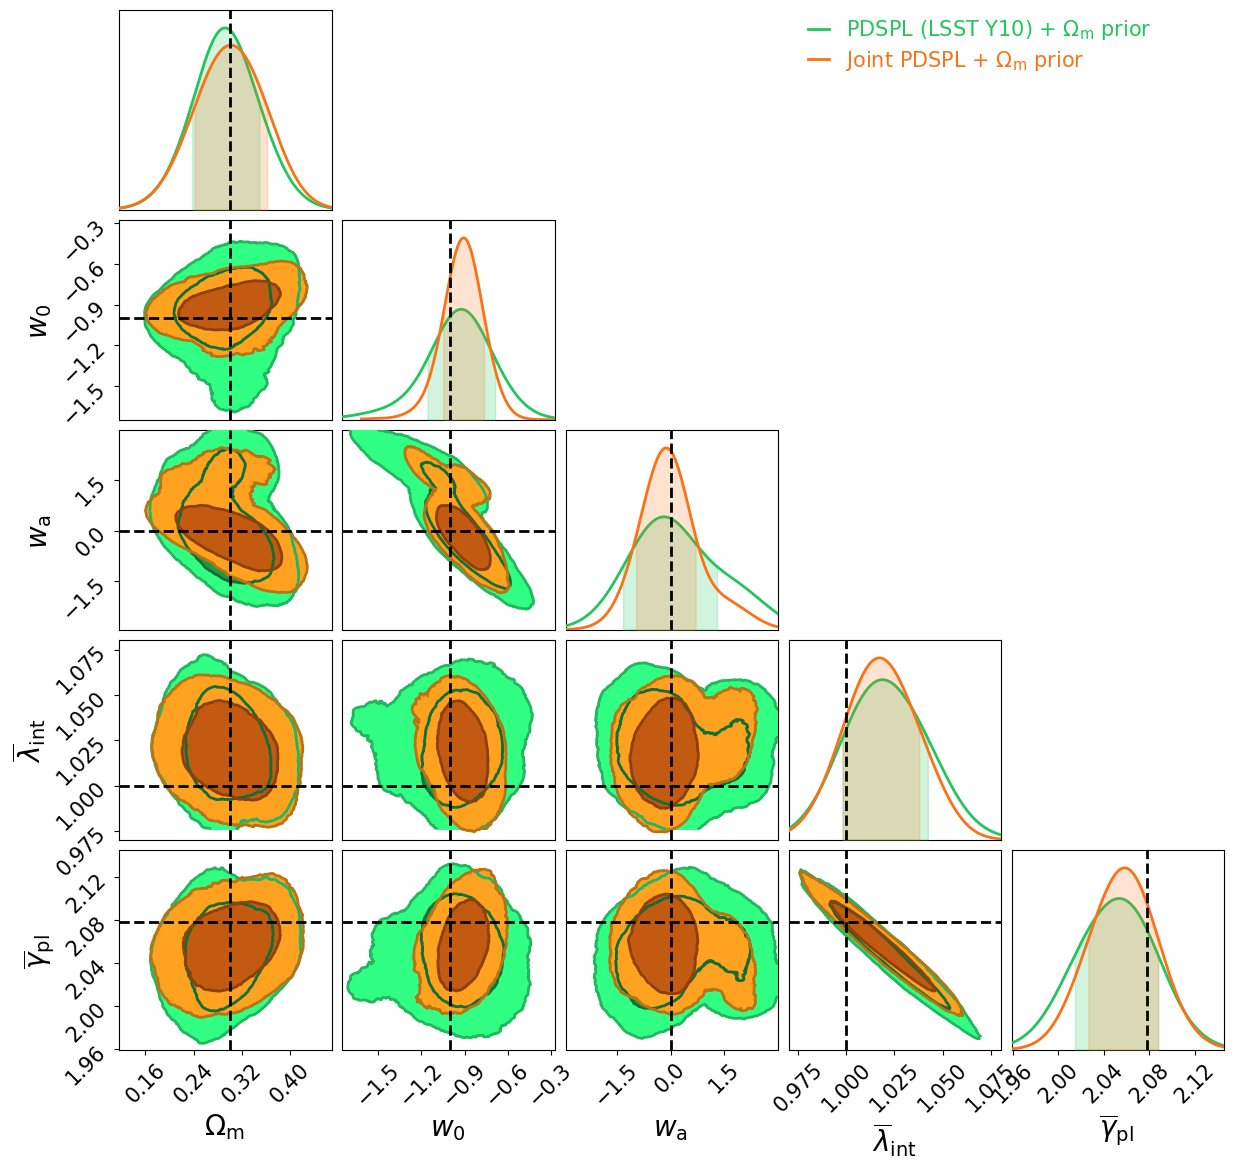

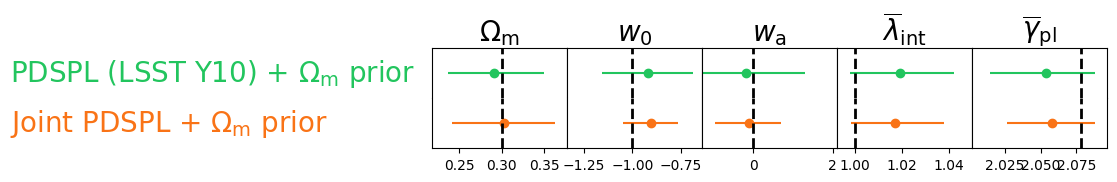

In [23]:
# plot the forecast results using chainconsumer

c = ChainConsumer()

for key in plotting_order_keys:
    c.add_chain(forecast_samples[key]["w0waCDM"]["chainconsumer_chain_with_prior"])

c.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": 0.3,
        r"$w_0$": -1,
        r"$w_{\rm a}$": 0,
        r"$\overline{\lambda}_{\rm int}$": 1.0,
        r"$\overline{\gamma}_{\rm pl}$": 2.078,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }, line_width=2)
)

extents = {
                r"$\Omega_{\rm m}$": [0.1, 0.5],
                r"$w_0$": [-2, 0],
                r"$w_{\rm a}$": [-3, 3],
                r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
                r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
                # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
            }

c.plotter.set_config(
    PlotConfig(
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
)

c.plotter.plot(
    filename = FIGURES_DIR + "forecast_w0waCDM_with_prior.pdf",
);

c.plotter.plot_summary(errorbar=True);
latex_table = c.analysis.get_latex_table()
print(latex_table)

## Figures for $w$-CDM cosmology forecast 

In [10]:
# load posterior samples
columns=[
            '$\\Omega_{\\rm m}$',
            '$w$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            ]


for key in forecast_samples.keys():
    forecast_samples[key]["wCDM"]["emcee_backend"] = emcee.backends.HDFBackend(
        POSTERIOR_DIR + f"{key}_wCDM.h5", read_only=True
    )
    samples = forecast_samples[key]["wCDM"]["emcee_backend"].get_chain(flat = True,
                                                                  discard=500,
                                                                  thin=100)
    forecast_samples[key]["emcee_samples"] = samples

    df = DataFrame(samples, columns=columns)
    forecast_samples[key]["wCDM"]["chainconsumer_chain"] = Chain(
        samples=df, name=forecast_samples[key]["name"], 
        color=forecast_samples[key]["color"],
        kde=1.5, 
        shade=True,
        shade_alpha=1.0,
        linewidth=2,
    )

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		DSPL (87 lenses) & $0.62^{+0.28}_{-0.33}$ & $-0.71^{+0.52}_{-0.72}$ & $0.877^{+0.101}_{-0.076}$ & $2.26^{+0.13}_{-0.16}$ \\ 
		PDSPL (4MOST $z^{\rm spec}$) & $0.17^{+0.33}_{-0.17}$ & $-1.41^{+0.58}_{-0.47}$ & $0.940^{+0.100}_{-0.091}$ & $2.16^{+0.15}_{-0.16}$ \\ 
		PDSPL (4MOST $z^{\rm spec}$ + $\sigma_{v, D}$) & $0.24^{+0.12}_{-0.14}$ & $-1.08^{+0.29}_{-0.36}$ & $0.880^{+0.066}_{-0.057}$ & $2.209^{+0.096}_{-0.104}$ \\ 
		PDSPL (LSST Y10) & $0.355^{+0.097}_{-0.090}$ & $-1.01^{+0.15}_{-0.16}$ & $0.985\pm 0.019$ & $2.111^{+0.036}_{-0.035}$ \\ 
		\hline
    \end{tabular}
\end{table}


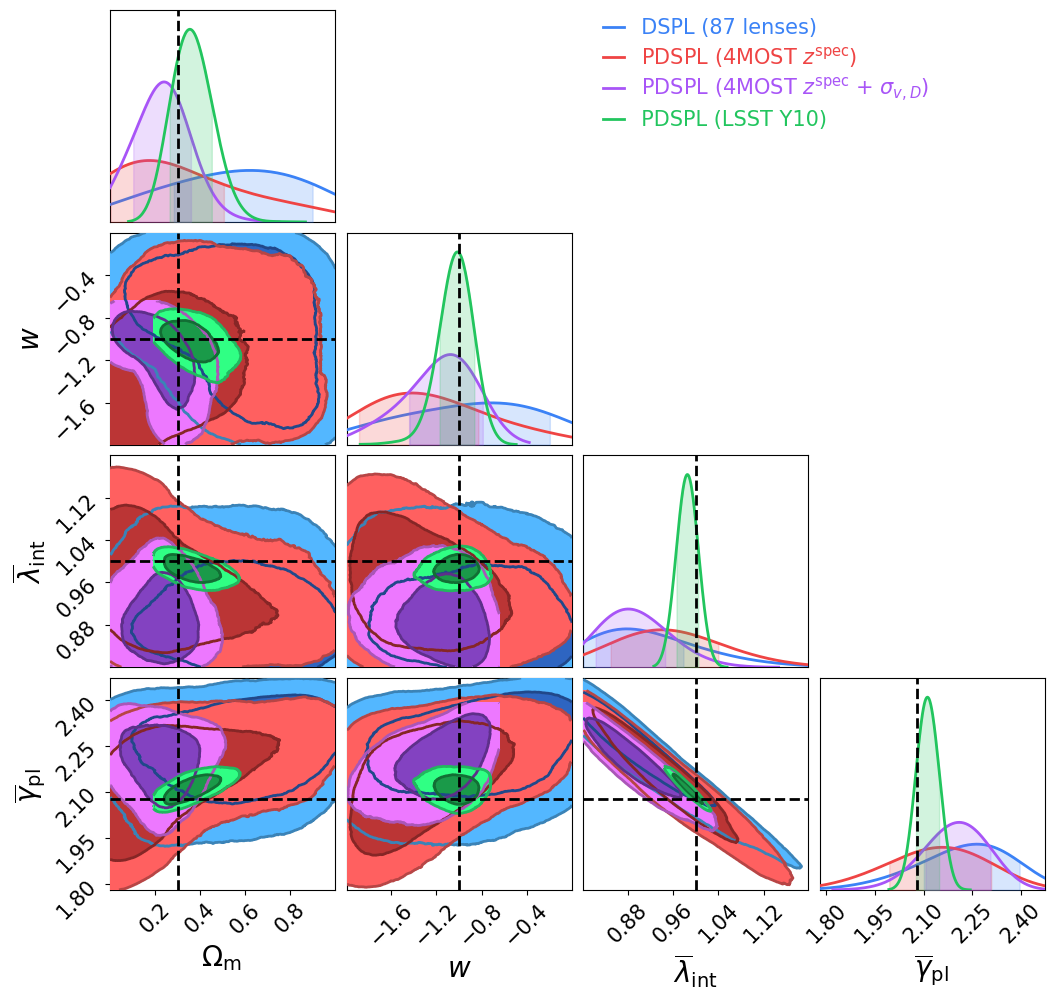

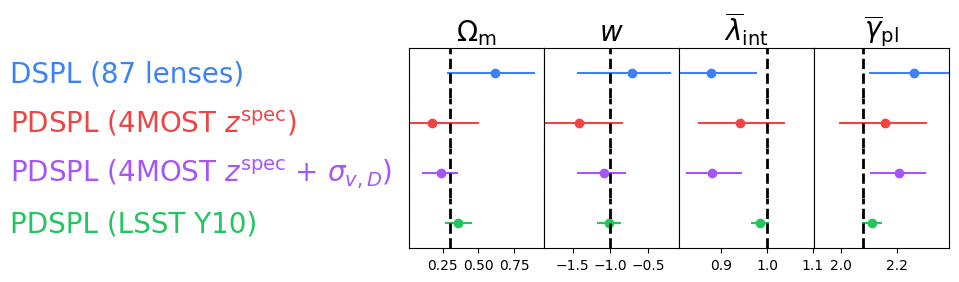

In [11]:
# plot the forecast results using chainconsumer

c = ChainConsumer()

for key in plotting_order_keys:
    c.add_chain(forecast_samples[key]["wCDM"]["chainconsumer_chain"])

c.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": 0.3,
        r"$w$": -1,
        r"$\overline{\lambda}_{\rm int}$": 1.0,
        r"$\overline{\gamma}_{\rm pl}$": 2.078,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }, line_width=2)
)

extents = {
                r"$\Omega_{\rm m}$": [0.1, 0.5],
                r"$w$": [-2, 0],
                r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
                r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
                # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
            }

c.plotter.set_config(
    PlotConfig(
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15, 
            label_font_size=20,
        )
)

c.plotter.plot(
    filename = FIGURES_DIR + "forecast_wCDM.pdf",
);


c.plotter.plot_summary(errorbar=True);
latex_table = c.analysis.get_latex_table()
print(latex_table)

### Prior on $\Omega_{\rm m}$

In [12]:
# external priors

# sigma_lambda_prior = 0.01
# sigma_gamma_prior = 0.01
sigma_omega_m_prior = 0.05
# sigma_wa_prior = 0.4

om_true = 0.3
w_true = -1


#flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

#print(joint_chain.samples[r"$\overline{\lambda}_{\rm int}$"])

def add_prior_to_chain(chain):
    chain_weights = copy.deepcopy(chain)
    # lambda_int = chain.samples[r"$\overline{\lambda}_{\rm int}$"]
    om = chain.samples[r"$\Omega_{\rm m}$"]
    # gamma_pl = chain.samples[r"$\overline{\gamma}_{\rm pl}$"]
    # wa = chain.samples[r"$w_{\rm a}$"]
    weights_om = -(om - om_true)**2 / (2*sigma_omega_m_prior**2)
    # weights_lambda = -(lambda_int - lambda_mst_mean)**2 / (2*sigma_lambda_prior**2)
    # weights_gamma = -(gamma_pl - gamma_pl_mean)**2 / (2*sigma_gamma_prior**2)
    # weights_wa = -(wa - wa_true)**2 / (2*sigma_wa_prior**2)
    # weights = np.exp(weights_gamma + weights_lambda + weights_om + weights_wa)
    weights = np.exp(weights_om)
    weights[weights < 10**(-10)] = 10**(-10)
    chain_weights.samples["weight"] = weights
    chain_weights.name = chain.name+" + $\\Omega_{\\rm m}$ prior"
    return chain_weights

In [13]:
for key in forecast_samples.keys():
    chain = forecast_samples[key]['wCDM']['chainconsumer_chain']
    chain_with_prior = add_prior_to_chain(chain)
    forecast_samples[key]['wCDM']['chainconsumer_chain_with_prior'] = chain_with_prior

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		DSPL (87 lenses) + $\Omega_{\rm m}$ prior & $0.312^{+0.059}_{-0.069}$ & $-0.63^{+0.50}_{-0.62}$ & $0.897^{+0.106}_{-0.089}$ & $2.23^{+0.14}_{-0.17}$ \\ 
		PDSPL (4MOST $z^{\rm spec}$) + $\Omega_{\rm m}$ prior & $0.288^{+0.066}_{-0.059}$ & $-1.25^{+0.56}_{-0.51}$ & $0.935^{+0.083}_{-0.081}$ & $2.16\pm 0.12$ \\ 
		PDSPL (4MOST $z^{\rm spec}$ + $\sigma_{v, D}$) + $\Omega_{\rm m}$ prior & $0.284^{+0.053}_{-0.052}$ & $-1.23^{+0.31}_{-0.36}$ & $0.883^{+0.066}_{-0.056}$ & $2.193^{+0.091}_{-0.097}$ \\ 
		PDSPL (LSST Y10) + $\Omega_{\rm m}$ prior & $0.316\pm 0.050$ & $-0.99\pm 0.12$ & $0.990\pm 0.018$ & $2.098^{+0.031}_{-0.030}$ \\ 
		\hline
    \end{tabular}
\end{table}


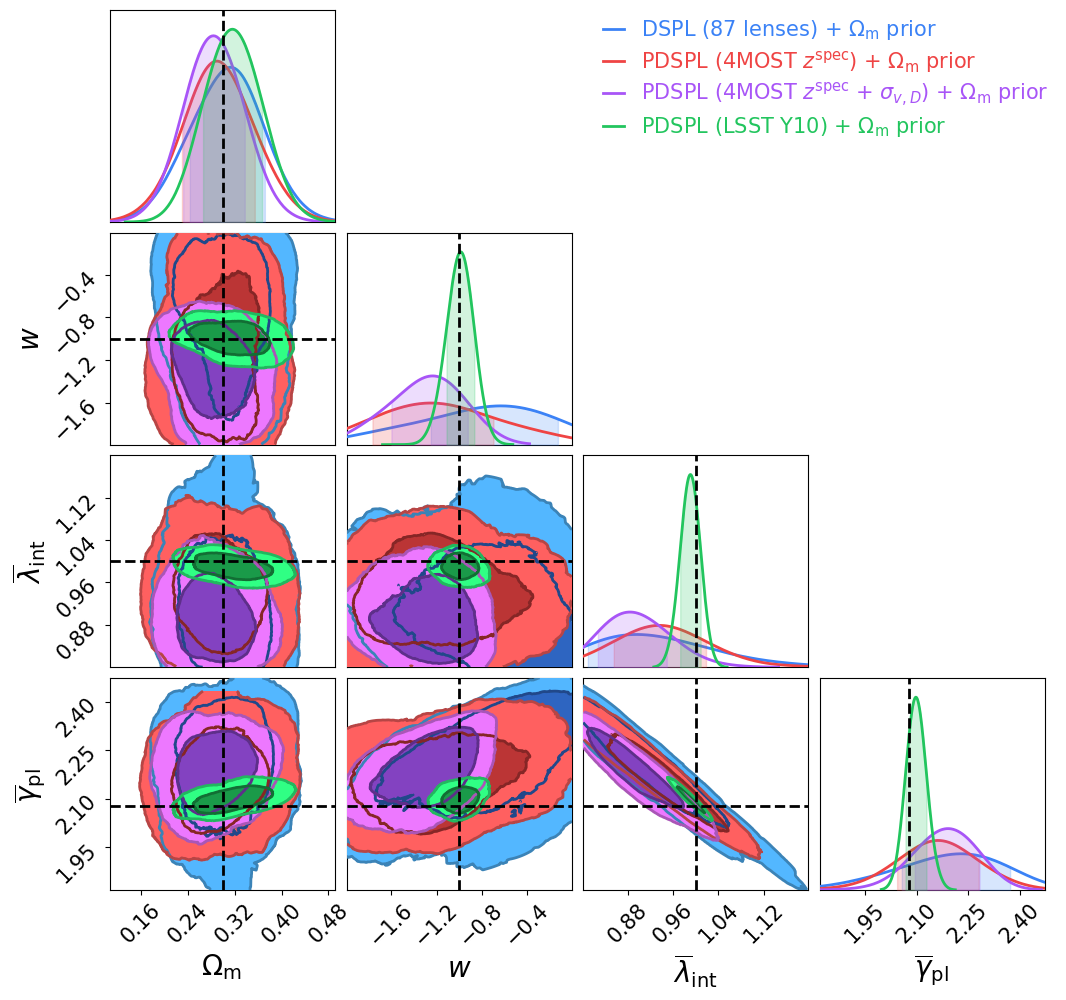

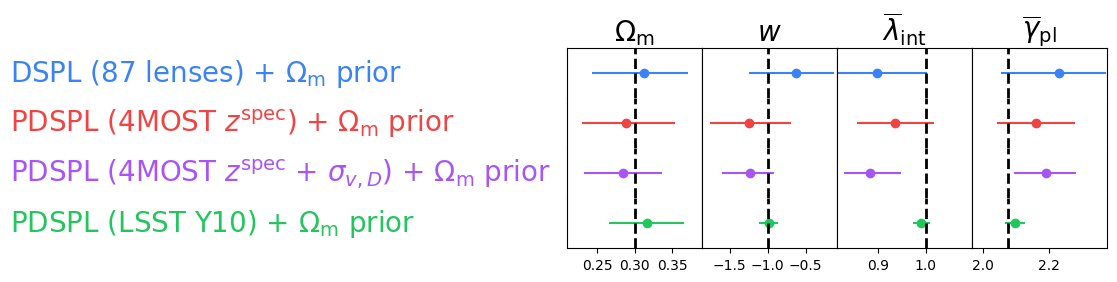

In [14]:
# plot the forecast results using chainconsumer

c = ChainConsumer()

for key in plotting_order_keys:
    c.add_chain(forecast_samples[key]['wCDM']['chainconsumer_chain_with_prior'])

c.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": 0.3,
        r"$w$": -1,
        r"$\overline{\lambda}_{\rm int}$": 1.0,
        r"$\overline{\gamma}_{\rm pl}$": 2.078,
        # r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }, line_width=2)
)

extents = {
                r"$\Omega_{\rm m}$": [0.1, 0.5],
                r"$w$": [-2, 0],
                r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
                r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
                # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
            }

c.plotter.set_config(
    PlotConfig(
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
)

c.plotter.plot(
    filename = FIGURES_DIR + "forecast_wCDM_with_prior.pdf",
);

c.plotter.plot_summary(errorbar=True);
latex_table = c.analysis.get_latex_table()
print(latex_table)